In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
# 이미지 섞기
# 랜덤한 위치, 크기의 bounding box 추출
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    return x_min, y_min, x_max, y_max

# 다른 이미지에 bounding box 대체
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    # image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    return mixed_img

# 라벨 섞기
# 섞인 이미지의 원본 이미지 비율에 따라 라벨링
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [ ]:
# mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

# mixup for dataset(batch)
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [ ]:
def onehot(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    label_one_hot = []

    for i in range(batch_size):
        label_one_hot.append(tf.one_hot(label[i], num_classes))

    imgs_reshape = tf.reshape(tf.stack(image), (batch_size, img_size, img_size, 3))
    labels_reshape = tf.reshape(tf.stack(label_one_hot), (batch_size, num_classes))
    return imgs_reshape, labels_reshape


In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, batch_size=16, is_test=False,
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )

    ds = ds.batch(batch_size)
    if not is_test:
        if with_cutmix:
            ds = ds.map(
                cutmix,
                num_parallel_calls=2
            )
        if with_mixup:
            ds = ds.map(
                mixup,
                num_parallel_calls=2
            )
        if not (with_cutmix or with_mixup):
            ds = ds.map(
                onehot,
                num_parallel_calls=2
            )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# 1. Augmentation을 적용한 데이터셋 만들기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = '../dataset/tf_dataset/', 
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../dataset/tf_dataset/stanford_dogs/0.2.0.incomplete3IY067/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../dataset/tf_dataset/stanford_dogs/0.2.0.incomplete3IY067/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to ../dataset/tf_dataset/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# 1.No Augmentation
# 2.기본 Augmentation
# 3.기본 + CutMix
# 4.기본 + Mixup
# 5.기본 + CutMix, Mixup

# type_aug = ['non', 'basic', 'cutmix', 'mixup', 'both'] 
type_aug = ['non', 'basic', 'cutmix', 'mixup'] 
ds_train_aug = [None for _ in range(len(type_aug))]

ds_train_aug[type_aug.index('non')] = apply_normalize_on_dataset(ds_train)
ds_train_aug[type_aug.index('basic')] = apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=True)
ds_train_aug[type_aug.index('cutmix')] = apply_normalize_on_dataset(ds_train, batch_size=16, 
                                                                    with_aug=True, with_cutmix=True)
ds_train_aug[type_aug.index('mixup')] = apply_normalize_on_dataset(ds_train, batch_size=16, 
                                                                    with_aug=True, with_mixup=True)
# ds_train_aug[type_aug.index('both')] = apply_normalize_on_dataset(ds_train, batch_size=16, 
#                                                                    with_aug=True, with_cutmix=True, with_mixup=True)
# 
ds_test_normal = apply_normalize_on_dataset(ds_test, is_test=True)


In [ ]:
ds_test_normal = apply_normalize_on_dataset(ds_test, is_test=True)


In [ ]:
ds_test_normal

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

# 2. 모델 만들기
- 모델은 ResNet-50을 사용

In [ ]:
num_classes = ds_info.features["label"].num_classes

# 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 불러오기
# include_top : 마지막 fully connected layer를 포함할지 여부

model_resnet50 = [None for _ in range(len(type_aug))]
for idx in range(len(model_resnet50)):
    resnet_ = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg'
    )
    model_resnet50[idx] = keras.models.Sequential(
        [resnet_, keras.layers.Dense(num_classes, input_shape=(224, 224, 3), activation='softmax')]
        )


94781440/94765736 [==============================] - 1s 0us/step


# 3. 모델 훈련하기
- sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [ ]:
EPOCH = 25

history_model = []
for idx in range(len(model_resnet50)):
    model_resnet50[idx].compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01),
        metrics=['accuracy'],
    )
    # augmentation 적용하지 않은 데이터셋 사용
    buf_history = model_resnet50[idx].fit(
        ds_train_aug[idx], 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test_normal,
        verbose=1,
        use_multiprocessing=True,
    )
    history_model.append(buf_history)


Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 118ms/step - loss: 2.1927 - accuracy: 0.4524 - val_loss: 3.0277 - val_accuracy: 0.2643
Epoch 2/25
750/750 [==============================] - 87s 116ms/step - loss: 0.6853 - accuracy: 0.8131 - val_loss: 1.1377 - val_accuracy: 0.6638
Epoch 3/25
750/750 [==============================] - 87s 116ms/step - loss: 0.1917 - accuracy: 0.9671 - val_loss: 0.9297 - val_accuracy: 0.7316
Epoch 4/25
750/750 [==============================] - 92s 123ms/step - loss: 0.0479 - accuracy: 0.9971 - val_loss: 0.9036 - val_accuracy: 0.7413
Epoch 5/25
750/750 [==============================] - 87s 116ms/step - loss: 0.0201 - accuracy: 0.9999 - val_loss: 0.9109 - val_accuracy: 0.7423
Epoch 6/25
750/750 [==============================] - 87s 117ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9259 - val_accuracy: 0.7432
Epoch 7/25
750/750 [==============================] - 87s 116ms/step - loss: 0.0115 - accuracy: 0.9998 - val_loss: 0.9531 - val_accuracy: 0.

# 4. 훈련 과정 시각화하기

In [ ]:
# save history
import csv
PATH_BASE = './drive/MyDrive/ws_colab/going_deeper/project/gd_4'
csv_file = [PATH_BASE+f'/save_history{idx}.csv'for idx in range(len(history_model))]

for idx in range(len(history_model)):
    his_ = history_model[idx].history
    key_ = list(his_.keys())
    with open(csv_file[idx], 'w') as csvfile: 
        writer = csv.DictWriter(csvfile, fieldnames=key_) 
        writer.writeheader() 
        writer.writerow(his_)


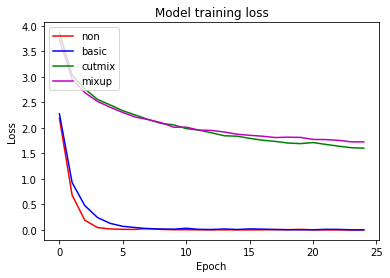

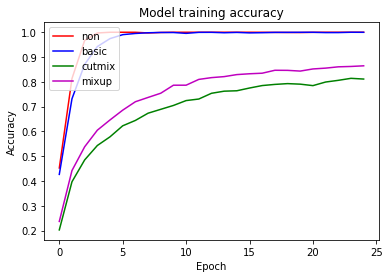

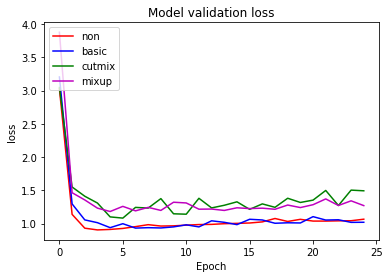

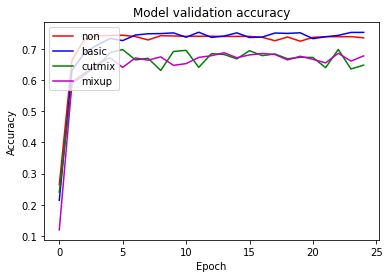

In [ ]:
color = ['r', 'b', 'g', 'm', 'y', 'c', 'k']

for idx in range(len(history_model)):
    plt.plot(history_model[idx].history['loss'], color[idx])
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(type_aug, loc='upper left')
plt.show()

for idx in range(len(history_model)):
    plt.plot(history_model[idx].history['accuracy'], color[idx])
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(type_aug, loc='upper left')
plt.show()

for idx in range(len(history_model)):
    plt.plot(history_model[idx].history['val_loss'], color[idx])
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(type_aug, loc='upper left')
plt.show()

for idx in range(len(history_model)):
    plt.plot(history_model[idx].history['val_accuracy'], color[idx])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(type_aug, loc='upper left')
plt.show()


# 5. Augmentation에 의한 모델 성능 비교
- 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석
    1. No Augmentation 
    2. 기본 Augmentation
    3. 기본 + CutMix 적용
    4. 기본 + Mixup 적용



- cutmix, mixiup을 적용한 경우보다 적용하지 않은 데이터셋이 더 좋은 결과를 보여줌
- cutmix, mixiup을 적용하지 않은 데이터셋은 기법을 적용하지 않아도 좋은 결과를 보여줌
- 기법을 적용하지 않은 데이터셋 이미 학습에 충분한 데이터를 제공
- 떄문에 기법을 적용한 것이 오히려 빠른 성능 달성에 좋지 않은 영향을 준것이 아닌가 하는 가설을 생각함
- 학습에 충분하지 않은 데이터로 실험을 통해 가설을 생각해볼 필요가 있음<br><br>

- cutmix와 mixiup를 적용한 데이터셋의 Traing acc는 지속적으로 증가하고 있음
- 떄문에 Epoch를 더 진행해볼 필요성도 있음 
    - 기법을 적용하지 않은 데이터셋보다 좋은 성능을 보일 가능성
    - 오버핏팅으로 점점 성능이 떨어질 가능성

- cutmix와 mixiup를 적용한 각각의 데이터셋은 mixup이 안정된 학습 그래프를 보임
- cutmix의 경우 무작위로 bounding box 이미지와 원본 이미지의 소실되는 부분이 정해짐
- 이러한 무작위성이 학습을 불안정하게 할 수 있지 않을까하는 가설을 생각함
    - label과 연관성이 떨어질 수도 있다고 생각
    - object와 background를 detection하여 cutmix를 변형에 대해 생각
        - background 중심의 cutmix로 불안정성을 낮출 수 있을 가능성에 대해 생각
        - object 중심의 cutmix로 cutmix의 효과를 높일 수 있을 가능성에 대해 생각
- 불안정하지만 지속적으로 학습 결과가 개선되고 있음
- 좋은 학습 결과를 얻을 수 없을때 이러한 불안정은 크게 의미가 없는 것에 대한 가능성을 생각
